# <span id="chap_er_networks_maths"></span> The mathematics of the ER model

So far we've looked at ER networks from a practical perspective, through simulation. This **numerical** approach is typical for computer scientists, and is very powerful. It has the enormous advantage of working for *any* network using the *same* set of techniques (and code). It has the enormous disadvantage, however, of often providing very little insight as to *why* the answer is as it is: why, for example, does an ER network have the [bell-shaped degree distribution](er-networks.ipynb#sec_er_networks_degree_distribution) that it has, and what does this imply?

Often the numerical approach is the best we can hope for, especially in the face of irregular or otherwise "awkward" networks. But the ER network has a very regular construction process: surely we might expect to be able to do better?

An alternative to simulation in such cases is to take an **analytical** approach, to try to find closed-form mathematical expressions that answer the key questions we want to pose. This approach omly works in some cases &ndash; although these cases are vitally important and interesting, and it turns out that there are other analytic techniques that work for a still broader class of networks &ndash; but it has the advantage of not requiring simulation that may be time-consuming and subject to various statistical constraints: analysis provides precise, uniform answers.     

In this chapter we'll look at some properties of ER networks from this perspective and derive mathematical expressions for them. We'll focus only on those properties that are most important from a practical perspective: the dergree distribution and the mean degree. (The [Wikipedia page for ER networks](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) describes &ndash; but doesn't derive &ndash; lots of other properties of largely theoretical interest.) We'll do this from first principles and at some length, to demonstrate the sorts of mathematical arguments that'll be common in what's to come.

## <span id="sec_er_networks_maths_degree_distribution"></span> Degree distribution

We'll start by returning to the degree distribution, the numbers of nodes with given numbers of immediate neighbours in the network. We observed [earlier](concepts-degree.ipynb#sec_concepts_degree_significance) that we can interpret the degree distribution in terms of probability: what is the probability of a node $v$ chosen at random having a given degree $k$? In normal probability notation this would be written $P(deg(v) = k)$, the probability that $deg(v)$, the degree of $v$, is equal to $k$. For brevity we will usually write this as $p_k$. Taken over the whole network, this will yield a degree distribution, where the probability of all possible degrees in the network sum to one: $\sum_k p_k = 1$.

So what is the degree distribution for an ER network? At first acquaintance, many non-mathematicians would argue something like this: the [generating process](er-networks.ipynb#sec_er_networks_building) adds an edge between any pair of nodes with a fixed probability $\phi$, with every edge (and every node) treated equally. Therefore, we'd expect every node to have roughly the same degree as every other &ndash; a degree distribution that's *uniform* &ndash; consistent with the uniformity of the generating process.

Does that sound reasonable? &ndash; it did to me when I first made this argument. But we know from [the simulation we did earlier](er-networks.ipynb#sec_er_networks_degrees) that this *isn't* what happens: we actually get a *normal* distribution of degrees, not a uniform one. (If you need more convincing about this, read the rest of this section and then skip to the [epilogue](#sec_epilogue) at the end of the chapter.) Clearly there must be another way of thinking about the process.

Let's re-phrase the question: in an ER network, how does a node end up having degree $k$? We can answer this by looking back at the [construction process](er-networks.ipynb#sec_er_networks_building), where we iterated through all the pairs of nodes and added an edge between them with a given, fixed, probability $\phi$ (which we denoted `pEdge` in the code).  So each node *could in principle* have been connected to $N - 1$ other nodes: that's the maximum degree it could have, since we've excluded the possibility of self-loops or parallel edges. For each of these potential edges, we essentially tossed a coin to decide whether the edge was included or not &ndash; except that the "coin" came down "heads" with a probability $\phi$, and therefore came down "tails" with a probability $(1 - \phi)$ (since there are only two alternatives, and their probabilities have to sum to 1). Let's refer to each such decision &ndash; add an edge or don't &ndash; as an *action*. For each node we perform $N - 1$ actions, one per potential edge, and for a node to have a degree $k$ we have to perform $k$ "add" actions and $(N - 1 - k)$ "don't-add" actions. We can perform these actions in any order.

How many ways are there to perform this sequence of actions? Suppose we have a bag of $a$ actions: how many ways are there to select $b$ actions from the bag? The answer to this is given by the formula $\frac{a!}{b! (a - b)!}$, a result known as the **binomial theorem**. This value is often denoted $\binom{a}{b}$, so:

$$
    \binom{a}{b} = \frac{a!}{b! \, (a - b)!}
$$

So, returning to our original question, we have $\binom{N - 1}{k}$ ways to perform $k$ "add" actions from a possible $N - 1$ actions, with the remainder being "don't-add" actions. This is the number of possible sequences that, for a given node, can result in that node having degree $k$. From elementary probability theory, to work out the probability of a sequence of actions happening we multiply-out the probabilities of the individual actions: "this *and* this *and* this" and so forth. So for each sequence of $k$ add actions and $(N - 1 - k)$ don't-add actions we multiply the probailities of each action together to get the probability of them *all* happening, and then multiply this compound probability by number of ways these actions can happen so as to still give us the $k$ edges we want.

Putting all this together, what is the probability that a node $v$ taken at random from an ER model consisting of $N$ nodes and edge probability $\phi$ will have degree $k$? For a node to have degree $k$ we need to perform a sequence of actions consisting of $k$ add actions (each occurring with probability $\phi$ ); *and*  we need $(N - 1 - k)$ don't-add actions (occurring with probability $1 - \phi$); *and* there are $\binom{N - 1}{k}$ ways in which these actions can be arranged. Expressing this as maths, we get:

$$
    p_k = \binom{N - 1}{k} \, \phi^k \, (1 - \phi)^{N - 1 - k}
$$

This is a distribution well known in statistics as the **binomial distribution**. It's important to note that $\phi$ is a constant, and that each add action is independent of each other add action: it doesn't get any easier to add edges over time. (If this seems like an obvious thing to say, we only say it because this turns out to be different to the approach we'll take to BA networks [later](powerlaw.ipynb).)

Given that we are dealing with large graphs, we will simplify the $N - 1$ term to $N$, since it makes very little difference as $N \rightarrow \infty$, yielding:

$$p_k = \binom{N}{k} \, \phi^k \, (1 - \phi)^{N - k}$$

What happens as $N$ gets larger and larger? Clearly $\binom{N}{k}$ also gets larger and larger (there are more and more ways to choose the $k$ edges), and $(1 - \phi)^{N - k}$ gets smaller and smaller (since $1 - \phi$ is by definition less than 1), while $\phi^k$ stays the same size. What happens therefore depends on whether the rise term or the falling term dominates in the limit, which isn't blindingly obvious but fortunately the answer *is* known: the binomial distribution converges to another distribution, the **Poisson distribution**, as $N \rightarrow \infty$. The Poisson distribution is basically the normal distribution for systems built from discrete events, and is given by:

$$p_k = \frac{(N\phi)^k e^{-N\phi}}{k!}$$

While this form is easier to work with, it's a lot less suggestive. The binomial form is probably to be preferred as a way of thinking about the distribution simply because each of the factors within it relates to a real, concrete phenomenon: add actions, don't-add actions, their probabilities (summing to 1), and the number of ways of combining them.

It's also worth noting that, in using an analytical approach, we were able to appeal to lots of known results in mathematics about the number of possible combinations of actios, or the ways functions behave in the limit &ndash; and with no need to write any code or burn any computer time.

## <span id="sec_er_networks_maths_mean_degree"></span> Mean degree

A useful number to know for a network is the [mean degree](concepts-degree.ipynb#sec_concepts_degree_summary), the degree of an "average" node, usually written $\langle k \rangle$. We can work this out numerically or (for regular structures like ER networks) analytically. Let's do both and compare the results.

In [1]:
import math
import numpy

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn

/Users/sd/programming/cncp/cncp/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We've already determined that the degree distrubution we're expecting is Poisson. Plotting a Poisson distribution will help understand where the mean degree comes from:

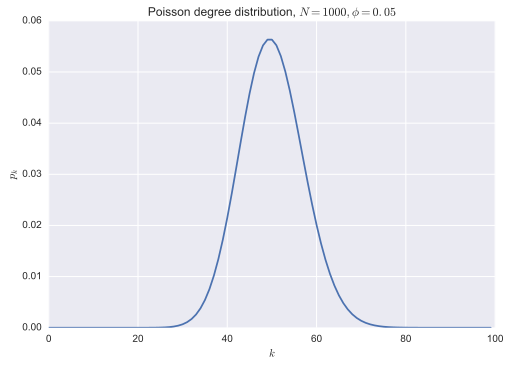

In [3]:
def poisson( n, pEdge ):
    '''Return a model function for the Poisson distribution with n nodes and
    edge probability pEdge.
    
    :param n: number of nodes
    :param pEdge: probabilty of an edge being added betweed a pair of nodes'''
    def model( k ):
        return (pow(n * pEdge, k) * math.exp(-n * pEdge)) / math.factorial(k)
    return model

fig = plt.figure()
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.title('Poisson degree distribution, $N = {n}, \phi = {phi}$'.format(n = 1000, phi = 0.05) )
plt.plot(xrange(100), map(poisson(1000, 0.05), xrange(100)))

_ = plt.show()

The graph is symmetric around the point $x = 50$, suggesting that this is the mean. Looking at the parameters of the distribution, however, we plotted 1000 nodes with an edge probability of 0.05, which multiplied-out also give 50. That's suggestive, but we need to *prove* that its the case *always*.

First let's re-visit the idea of a mean. The mean of any random variable can be written as the sum of each value the variable can take m,ultiplied by the probability of it taking that value. For the mean degree, we therefore have:

\begin{align}
    \langle k \rangle &= 1 \times p_1 + 2 \times p_2 + \cdots \\
                      &= \sum_{k = 1}^N k \, p_k
\end{align}

(The maximum node degree is actually $N - 1$ since we're looking at simple networks, so we only really need to sum $k$ up to $N-1$ rather than $N$ &ndash; but that just means that $p_N = 0$, so the sum works out anyway.) For the Poisson distribution underlying an ER network, we can code-up this definition using the formula above to work out the probability for each $k$. If $N = 1000$ and $\phi = 0.05$ as above, then:

In [4]:
sum = 0
p = poisson(1000, 0.05)
for k in xrange(1, 100):
    sum = sum + k * p(k)
print 'Computed mean degree = {kmean}'.format(kmean = sum)

Computed mean degree = 49.9999999677


Close enough. But we can do better: we can obtain an analytic result and compute the formula for the mean degree given $N$ and $\phi$. We can identify the two definitions above to get that:

$$
    \langle k \rangle = \sum_{k = 1}^N k \, \binom{N}{k} \, \phi^k \, (1 - \phi)^{N - k}
$$

So we need to find out the value of the sum on the right-hand side. To do this we need to know another property of the binomial distribution, which is that:

$$
    (p + q)^n = \sum_{d = 1}^{n} d \binom{n}{d} \, p^d \, q^{n - d}
$$

Now, if we differentiate both sides with respect to $p$, we get:

\begin{align*}
     n(p + q)^{n - 1} &= \sum_{d = 1}^{n} \binom{n}{d} \, d \, p^{d - 1} \, q^{n - d} \\
                      &= \frac{1}{p} \sum_{d = 0}^{n} d \binom{n}{d} \, p^d \, q^{n - d} \\
    np(p + q)^{n - 1} &= \sum_{d = 1}^{n} d \binom{n}{d} \, p^d \, q^{n - d}
\end{align*}

and the right-hand side starts to look very like the form we're looking for from above. If we now express it in terms of $N$, $\phi$, and $k$ to get the notation straight, and let $q = 1 - p$, then:

\begin{align*}
    N\phi(\phi + (1 - \phi))^{N - 1} &= \sum_{k = 1}^{N} \binom{N}{k} \, \phi^k \, (1 - \phi)^{N - k} \\
                               N\phi &= \sum_{k = 1}^{N} \binom{N}{k} \, \phi^k \, (1 - \phi)^{N - k} \\
                                     &= \langle k \rangle
\end{align*}

So the mean of the binomial degree distribution is given by $N \phi$. Looking at the equations, we can see that $N$ and $\phi$ are the only parameters: we need to know them, *and only them*, to compute the distribution for any value of $k$. We can therefore say that $N$ and $\phi$ *completely characterise* the distribution.

### <span id="sec_er_networks_maths_poisson_mean_degree"></span> Making use of the mean degree

There is another implication of this. Since $\langle k \rangle = N\phi$, for large $N$ we can make use of the fact that the binomial distribution converges to the Poisson distribution and re-write the probability distribution for at ER network in terms of the network's mean degree:

$$
    p_k = \frac{\langle k \rangle^k e^{-\langle k \rangle}}{k!}
$$

This means that given two of $N$, $\phi$, and $\langle k \rangle$, we can compute the other, and we have all we need to completely characterise the degree distribution of an ER network. Put still another way, if we want an ER network with a specific number of nodes and a mean degree, we can compute the link probability $\phi = \frac{\langle k \rangle}{N}$ we need to construct it.

## <span id="sec_er_networks_maths_epilogue"></span> Epilogue: why *isn't* the degree distribution uniform?

Earlier we asserted that many people, on first seeing the generating process for the ER model, assume that it will result in a uniform degree distribution. I certainly did. Since it's such a common reaction, it's perhaps worth exploring a little why it's also wrong.

The argument for a uniform degree distribution goes roughly as follows: since the edge probability is independent for every edge, we'd expect that, at each node, we select roughly the same number of edges to add, and therefore there's no reason for one node to be preferred over another, so they should all have roughly the same degree.

The problem here is that it takes a statement about *edges* and subtly converts it into a statement about *nodes*. Just because we select edges with a constant probability doesn't imply that we do so uniformly at the node level &ndash; so uniformly, in fact, that every node ends up having *exactly* the same number of edges. Put that way, a uniform degree distribution actually sounds rather unlikely! The process only says that, *over the graph as a whole*, edges are added with constant probability: it does not say anything about the *local* behaviour of edge addition around an individual node. It is this that allows for the possibility of non-uniform distrbution.

This observation &ndash; that global behaviour, and typically global regularity, doesn't lead to local regularity &ndash; is perhaps the single most important thing to bear in mind about complex networks. It's tempting to think that large-scale regularity emerges from lots of small-scale regularity, but that isn't necessarily the case: the small scale could be irregular, but the irregularities could even out. Conversely, it's tempting to think that something that looks regular and well-behaved on the outside has component pieces that are regular and well-behaved &ndash; and again that isn't necessarily the case. The lesson here is that things can be more complex than they seem. On the other hand, it also means that we can often ignore local noise and make use of global properties, as long as we're careful.

The description we used for the ER generator is an example of a process that in mathematics is called a [Bernoulli process](https://en.wikipedia.org/wiki/Bernoulli_process), where we look at the sequence of actions needed to generate a given outcome and compute how many ways there are for those actions to occur at random. Bernoulli processes occur whenever we encounter actions being performed one after the other according to some random driver, and the [argument above](#sec_er_degree_distribution) is completely typical of how one deals with them.